# Modern Low Footprint Cyber Attack Detection - Project 1
CSC 215 Artificial Intelligence
Under the guidance of Prof. Haiquan Chen
Team Members: Swapnali Shrikhande, Asmita Shrivastav

# Imports and utility functions

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from sklearn.utils import resample

def plot_confusion_matrix(cm, names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Fetch dataset

In [2]:
#path = './data/'
#training_file = os.path.join(path,"UN'UNSW_NB15_training-set_csc215.csv'SW_NB15_training-set_csc215.csv")
df_train = pd.read_csv('UNSW_NB15_training-set_csc215.csv')

#test_file = os.path.join(path,"UNSW_NB15_test-set_csc215.csv")
df_test = pd.read_csv('UNSW_NB15_test-set_csc215.csv')

df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


# Additional feature : Downsampling

In [3]:
#count majority
df_train.label.value_counts()

1    119341
0     56000
Name: label, dtype: int64

In [4]:
df_train_majority = df_train[df_train.label==1]
df_train_minority = df_train[df_train.label==0]

df_train_majority_downsampled = resample(df_train_majority, replace = False, n_samples = 56000, random_state = 123)

df_train_downsampled = pd.concat([df_train_majority_downsampled, df_train_minority])
df_train = df_train_downsampled

# Y train-test dataset

In [5]:
y_train = df_train.loc[:,df_train.columns=='label']
y_test = df_test.loc[:,df_test.columns=='label']

# Co-relation matrix

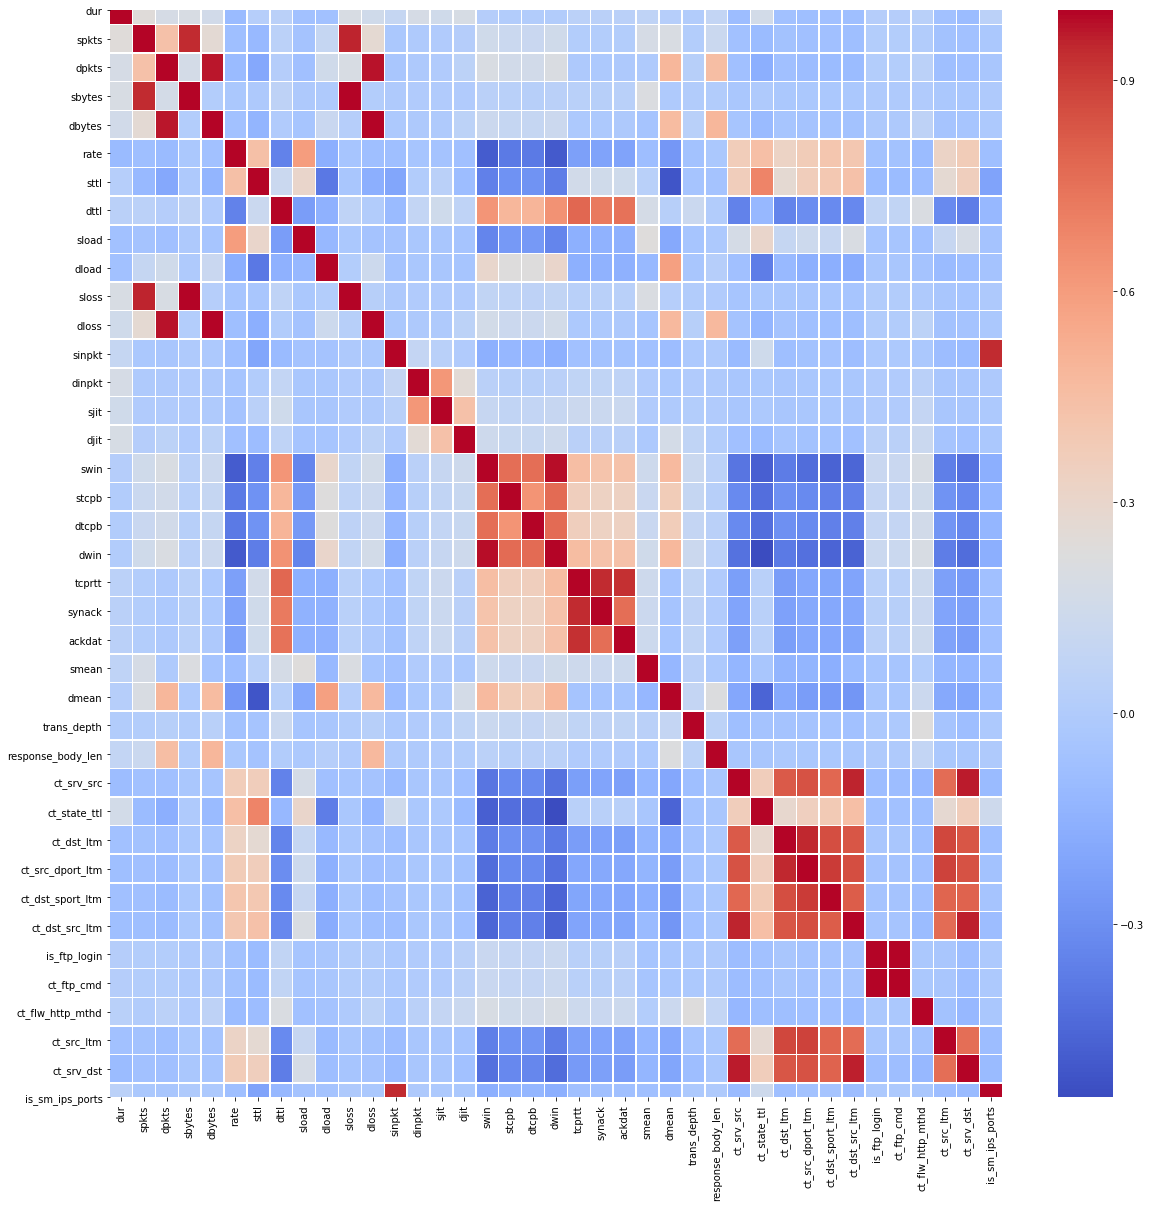

In [6]:
#drop unrelated nomial features
df_train.drop(['id','label','attack_cat','proto','service','state'],axis=1, inplace=True)
df_test.drop(['id','label','attack_cat','proto','service','state'],axis=1, inplace=True)

corr = df_train.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr,ax = ax, cmap= 'coolwarm',linewidth=.5)

# Segregate > 0.95 correlation

In [7]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = df_train.columns[columns]

print(selected_columns)

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'rate', 'sttl', 'dttl', 'sload',
       'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login',
       'ct_flw_http_mthd', 'ct_src_ltm', 'is_sm_ips_ports'],
      dtype='object')


# Drop Columns

In [8]:
unrelated_features = ['sbytes','dbytes','sloss','dloss','dwin','ct_ftp_cmd','ct_srv_dst','ct_src_dport_ltm', 'ct_dst_src_ltm']

df_train.drop(unrelated_features, axis=1,inplace=True)
df_test.drop(unrelated_features, axis=1, inplace=True)

df_train.head()

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,...,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports
151499,0.000006,2,0,166666.660800,254,0,7.600000e+07,0.00000,0.006000,0.000000,...,0,0,17,2,17,17,0,0,17,0
65641,0.284219,10,10,66.849859,62,252,2.119492e+04,118218.69530,31.579889,27.422444,...,1,1868,1,1,1,1,0,1,1,0
174998,0.279691,10,8,60.781360,62,252,2.108041e+04,48968.32422,31.076778,33.412430,...,1,547,1,1,1,1,0,1,1,0
78162,0.000003,2,0,333333.321500,254,0,2.666667e+08,0.00000,0.003000,0.000000,...,0,0,5,2,2,2,0,0,2,0
144927,0.000003,2,0,333333.321500,254,0,1.520000e+08,0.00000,0.003000,0.000000,...,0,0,38,2,5,5,0,0,5,0


# Data normalization : z-score

In [9]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd
    
for feature in df_train.columns:
    encode_numeric_zscore(df_train, feature)
    encode_numeric_zscore(df_test, feature)
    
x_train = df_train
x_test = df_test

x_train

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,...,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports
151499,-0.208354,-0.165946,-0.215621,0.616546,0.930644,-0.721668,0.090197,-0.350977,-0.164625,-0.084384,...,-0.127873,-0.051439,0.884866,0.884033,1.596036,2.599616,-0.122334,-0.199931,1.439656,-0.159009
65641,-0.161812,-0.103513,-0.126783,-0.488239,-0.818870,1.677858,-0.332526,-0.311111,-0.161109,-0.060728,...,1.100518,-0.014464,-0.750783,-0.086261,-0.620242,-0.459184,-0.122334,1.360943,-0.688886,-0.159009
174998,-0.162554,-0.103513,-0.144551,-0.488279,-0.818870,1.677858,-0.332527,-0.334464,-0.161165,-0.055561,...,1.100518,-0.040612,-0.750783,-0.086261,-0.620242,-0.459184,-0.122334,1.360943,-0.688886,-0.159009
78162,-0.208355,-0.165946,-0.215621,1.721774,0.930644,-0.721668,1.151010,-0.350977,-0.164626,-0.084384,...,-0.127873,-0.051439,-0.341871,0.884033,-0.481725,-0.268009,-0.122334,-0.199931,-0.555852,-0.159009
144927,-0.208355,-0.165946,-0.215621,1.721774,0.930644,-0.721668,0.513039,-0.350977,-0.164626,-0.084384,...,-0.127873,-0.051439,3.031655,0.884033,-0.066173,0.305516,-0.122334,-0.199931,-0.156751,-0.159009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115956,-0.208355,-0.173750,-0.215621,-0.488682,-1.383817,-0.721668,-0.332644,-0.350977,-0.164626,-0.084384,...,-0.127873,-0.051439,-0.648555,0.884033,-0.481725,-0.268009,-0.122334,-0.199931,-0.555852,6.288877
115957,9.616391,-0.165946,-0.215621,-0.488682,-1.383817,-0.721668,-0.332644,-0.350977,6.517456,-0.084384,...,-0.127873,-0.051439,-0.648555,0.884033,-0.481725,-0.268009,-0.122334,-0.199931,-0.555852,6.288877
115960,9.616391,-0.165946,-0.215621,-0.488682,-1.383817,-0.721668,-0.332644,-0.350977,6.517457,-0.084384,...,-0.127873,-0.051439,-0.648555,0.884033,-0.481725,-0.268009,-0.122334,-0.199931,-0.555852,6.288877
115961,9.616391,-0.165946,-0.215621,-0.488682,-1.383817,-0.721668,-0.332644,-0.350977,6.517456,-0.084384,...,-0.127873,-0.051439,-0.648555,0.884033,-0.481725,-0.268009,-0.122334,-0.199931,-0.555852,6.288877


In [ ]:
y_train

# LRM - Logistic Regression model

In [10]:
#fit model
LR_classifier = LogisticRegression()
LR_classifier.fit(x_train, y_train)

#predict
lrm_prediction = LR_classifier.predict(x_test)

C:\Users\27ash\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\27ash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# LRM - accuracy, recall, precision, F1-score

In [11]:
print(classification_report(y_test, lrm_prediction))
print("Accuracy: ", accuracy_score(y_test, lrm_prediction))

              precision    recall  f1-score   support

           0       0.58      0.98      0.73     37000
           1       0.97      0.43      0.60     45332

    accuracy                           0.68     82332
   macro avg       0.78      0.71      0.66     82332
weighted avg       0.80      0.68      0.66     82332

Accuracy:  0.6782660447942477


# LRM - confusion matrix

[[36368   632]
 [25857 19475]]


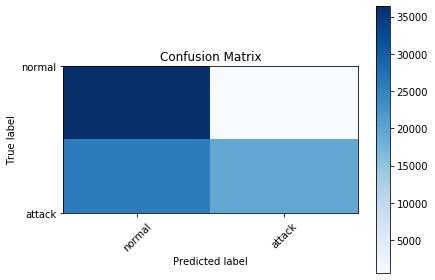

In [12]:
cm = confusion_matrix(y_test, lrm_prediction)
print(cm)
plt.figure()
plot_confusion_matrix(cm,['normal','attack'])
plt.show()

# LRM - ROC curve

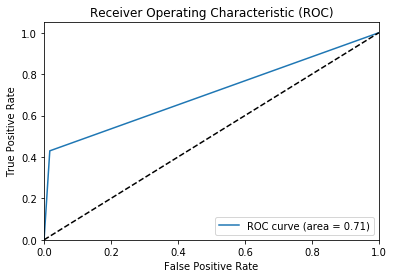

In [13]:
plot_roc(lrm_prediction, y_test)

# KNN - K-nearest neighbor model

In [ ]:
#fit model
kclassifier = KNeighborsClassifier(n_neighbors = 5)
kclassifier.fit(x_train, y_train)

#predict
knn_prediction = kclassifier.predict(x_test)

# KNN - accuracy, recall, precision, F1-score

In [ ]:
print(classification_report(y_test, knn_prediction))
print("Accuracy: ", accuracy_score(y_test, knn_prediction))

# KNN - confusion matrix

In [ ]:
cm = confusion_matrix(y_test, knn_prediction)
plt.figure()
plot_confusion_matrix(cm,['normal','attack'])
plt.show()

# KNN - ROC curve

In [ ]:
plot_roc(knn_prediction, y_test)

# SVM - Support Vector Machine model

In [ ]:
#fit model
svc_model = SVC(C=100, kernel='rbf', gamma='scale', class_weight='balanced')
svc_model.fit(x_train, y_train)

#predict
svm_prediction = svc_model.predict(x_test)

# SVM - accuracy, recall, precision, F1-score

In [ ]:
print(classification_report(y_test, svm_prediction))
print("Accuracy: ", accuracy_score(y_test, svm_prediction))

# SVM - confusion matrix

In [ ]:
plot_confusion_matrix(cm,['normal','attack'])
plt.show()

# SVM - ROC curve

In [ ]:
plot_roc(svm_prediction, y_test)

# NN1 - Fully-connected Neural Networks model - 3 layers

In [ ]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:
        
        if opt=='sgd':
            pt_opt =  SGD(lr=0.1, momentum=0.8, decay=0.1/1000, nesterov=False)
        else:
            pt_opt = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)
        
        print("\n\n optimizer:" + opt + "\t activation_functions :" + act)

        neural_model1 = Sequential()
        neural_model1.add(Dense(35, input_dim = x_train.shape[1], activation = act))
        neural_model1.add(Dense(31, activation = act))
        neural_model1.add(Dense(y_train.shape[1], activation = 'sigmoid'))

        neural_model1.compile(loss='binary_crossentropy', optimizer = pt_opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

        filepath="weights-improvement-{epoch:02d}.hdf5"
        checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
        neural_model1.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
        
        #prediction
        pred= neural_model1.predict(x_test)
       # pred_binary = np.argmax(pred,axis=1)
       
        
        #Acccuracy
        print("\nAccuracy: ", accuracy_score(y_test, pred.round()))
        
        print("\nClassification")
        print(classification_report(y_test, pred.round()))
        
        #cm
        cm =confusion_matrix(y_test,pred.round())
        print("\nconfusion matrix :\n ",cm )
        
        #PLOT CM
        plot_confusion_matrix(cm,['normal','attack'])
        plt.show()
        
        
        plot_roc(pred.round(),y_test)
        
        


# NN2 - Fully-connection Neural Networks model - (4 layers)



 optimizer:adam	 activation_functions :relu
Train on 112000 samples, validate on 82332 samples
Epoch 1/1000
112000/112000 - 13s - loss: 0.6765 - val_loss: 0.6880
Epoch 2/1000
112000/112000 - 12s - loss: 0.6954 - val_loss: 0.7005
Epoch 3/1000
112000/112000 - 12s - loss: 0.6950 - val_loss: 0.6902
Epoch 4/1000
112000/112000 - 12s - loss: 0.6952 - val_loss: 0.7020
Epoch 5/1000
112000/112000 - 12s - loss: 0.6954 - val_loss: 0.6914
Epoch 6/1000
112000/112000 - 12s - loss: 0.6953 - val_loss: 0.7079
Epoch 00006: early stopping

Accuracy:  0.44939999028324346

Classification


C:\Users\27ash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.45      1.00      0.62     37000
           1       0.00      0.00      0.00     45332

    accuracy                           0.45     82332
   macro avg       0.22      0.50      0.31     82332
weighted avg       0.20      0.45      0.28     82332


confusion matrix :
  [[37000     0]
 [45332     0]]


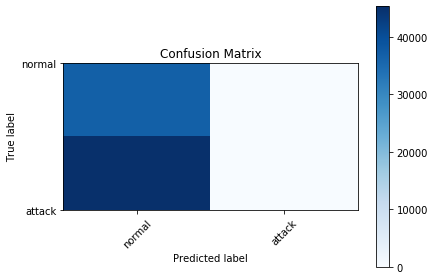

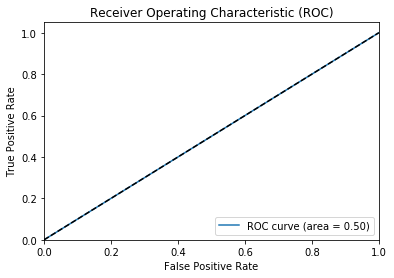



 optimizer:adam	 activation_functions :sigmoid
Train on 112000 samples, validate on 82332 samples
Epoch 1/1000
112000/112000 - 12s - loss: 0.2492 - val_loss: 0.3616
Epoch 2/1000
112000/112000 - 12s - loss: 0.2316 - val_loss: 0.3809
Epoch 3/1000
112000/112000 - 12s - loss: 0.2369 - val_loss: 0.3994
Epoch 4/1000
112000/112000 - 12s - loss: 0.2375 - val_loss: 0.4147
Epoch 5/1000
112000/112000 - 12s - loss: 0.2336 - val_loss: 0.3639
Epoch 6/1000
112000/112000 - 12s - loss: 0.2217 - val_loss: 0.3644
Epoch 00006: early stopping

Accuracy:  0.8310498955448671

Classification
              precision    recall  f1-score   support

           0       0.91      0.69      0.79     37000
           1       0.79      0.95      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.85      0.82      0.82     82332
weighted avg       0.85      0.83      0.83     82332


confusion matrix :
  [[25457 11543]
 [ 2367 42965]]


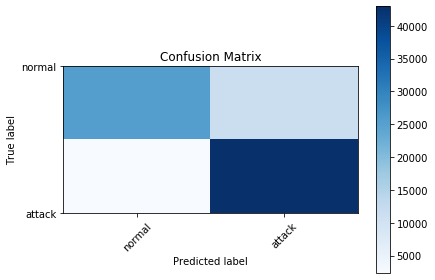

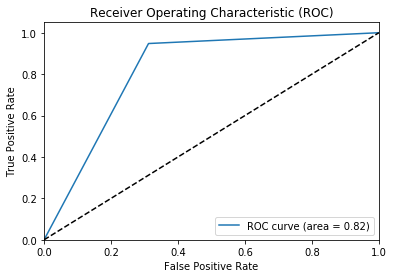



 optimizer:adam	 activation_functions :tanh
Train on 112000 samples, validate on 82332 samples
Epoch 1/1000
112000/112000 - 13s - loss: 0.2960 - val_loss: 0.5432
Epoch 2/1000
112000/112000 - 12s - loss: 0.2982 - val_loss: 0.4839
Epoch 3/1000
112000/112000 - 12s - loss: 0.2870 - val_loss: 0.5539
Epoch 4/1000
112000/112000 - 12s - loss: 0.2850 - val_loss: 0.4315
Epoch 5/1000
112000/112000 - 12s - loss: 0.2893 - val_loss: 0.4400
Epoch 6/1000
112000/112000 - 12s - loss: 0.2888 - val_loss: 0.5170
Epoch 7/1000
112000/112000 - 11s - loss: 0.2879 - val_loss: 0.4368
Epoch 8/1000
112000/112000 - 11s - loss: 0.2867 - val_loss: 0.4962
Epoch 9/1000
112000/112000 - 11s - loss: 0.2673 - val_loss: 0.4990
Epoch 00009: early stopping

Accuracy:  0.7775712967011612

Classification
              precision    recall  f1-score   support

           0       0.73      0.81      0.77     37000
           1       0.83      0.75      0.79     45332

    accuracy                           0.78     82332
   macr

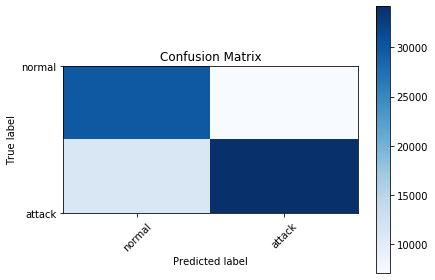

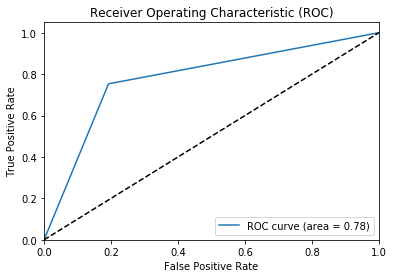



 optimizer:sgd	 activation_functions :relu
Train on 112000 samples, validate on 82332 samples
Epoch 1/1000
112000/112000 - 12s - loss: 0.1714 - val_loss: 0.3064
Epoch 2/1000
112000/112000 - 7s - loss: 0.1492 - val_loss: 0.3710
Epoch 3/1000
112000/112000 - 6s - loss: 0.1450 - val_loss: 0.3267
Epoch 4/1000
112000/112000 - 6s - loss: 0.1426 - val_loss: 0.4062
Epoch 5/1000
112000/112000 - 8s - loss: 0.1406 - val_loss: 0.3016
Epoch 6/1000
112000/112000 - 11s - loss: 0.1389 - val_loss: 0.2954
Epoch 7/1000
112000/112000 - 11s - loss: 0.1376 - val_loss: 0.2975
Epoch 8/1000
112000/112000 - 11s - loss: 0.1363 - val_loss: 0.3148
Epoch 9/1000
112000/112000 - 11s - loss: 0.1353 - val_loss: 0.3122
Epoch 10/1000
112000/112000 - 12s - loss: 0.1344 - val_loss: 0.3441
Epoch 11/1000
112000/112000 - 11s - loss: 0.1333 - val_loss: 0.3789
Epoch 00011: early stopping

Accuracy:  0.830163241509984

Classification
              precision    recall  f1-score   support

           0       0.91      0.69      0

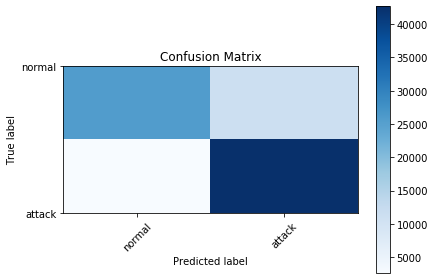

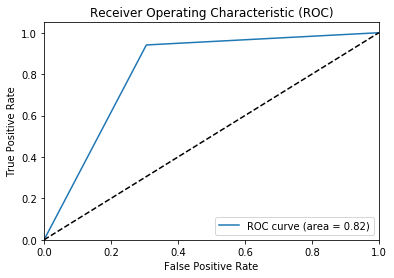



 optimizer:sgd	 activation_functions :sigmoid
Train on 112000 samples, validate on 82332 samples
Epoch 1/1000


In [ ]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:
        
        if opt=='sgd':
            pt_opt =  SGD(lr=0.1, momentum=0.8, decay=0.1/1000, nesterov=False)
        else:
            pt_opt = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)
        
        print("\n\n optimizer:" + opt + "\t activation_functions :" + act)

        neural_model2 = Sequential()
        neural_model2.add(Dense(50, input_dim = x_train.shape[1], activation = act))
        neural_model2.add(Dense(25, activation = act))
        neural_model2.add(Dense(12, activation = act))
        neural_model2.add(Dense(y_train.shape[1], activation = 'sigmoid'))

        neural_model2.compile(loss='binary_crossentropy', optimizer = pt_opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

        filepath="weights-improvement-{epoch:02d}.hdf5"
        checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
        neural_model2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
        
        #prediction
        pred= neural_model2.predict(x_test)
              
        #Acccuracy
        print("\nAccuracy: ", accuracy_score(y_test, pred.round()))
        
        print("\nClassification")
        print(classification_report(y_test, pred.round()))
        
        #cm
        cm =confusion_matrix(y_test,pred.round())
        print("\nconfusion matrix :\n ",cm )
        
        #PLOT CM
        plot_confusion_matrix(cm,['normal','attack'])
        plt.show()
        
        
        plot_roc(pred.round(),y_test)  

# NN3 - 3 layers(relu,tanh, sigmoid) using sgd

In [ ]:
neural_model3 = Sequential()
neural_model3.add(Dense(35, input_dim = x_test.shape[1], activation = 'relu'))
neural_model3.add(Dense(31, activation = 'tanh'))
neural_model3.add(Dense(y_test.shape[1], activation = 'sigmoid'))

sgd = SGD(lr=0.1, momentum=0.8, decay=0.1/1000, nesterov=False)

neural_model3.compile(loss='binary_crossentropy', optimizer = sgd)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

filepath="weights-improvement-{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
neural_model3.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

In [ ]:
pred= neural_model3.predict(x_test)
          
#Acccuracy
print("\nAccuracy: ", accuracy_score(y_test, pred.round()))

print("\nClassification")
print(classification_report(y_test, pred.round()))

#cm
cm =confusion_matrix(y_test,pred.round())
print("\nconfusion matrix :\n ",cm )


#PLOT CM
plot_confusion_matrix(cm,['normal','attack'])
plt.show()


plot_roc(pred.round(),y_test)
          

# NN4 - 3 layers(relu,tanh, sigmoid) using adam

In [ ]:
neural_model4 = Sequential()
neural_model4.add(Dense(35, input_dim = x_test.shape[1], activation = 'relu'))
neural_model4.add(Dense(31, activation = 'tanh'))
neural_model4.add(Dense(y_test.shape[1], activation = 'sigmoid'))

adam= Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

neural_model4.compile(loss='binary_crossentropy', optimizer = adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

filepath="weights-improvement-{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
neural_model4.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

In [ ]:
pred= neural_model4.predict(x_test)
          
#Acccuracy
print("\nAccuracy: ", accuracy_score(y_test, pred.round()))

print("\nClassification")
print(classification_report(y_test, pred.round()))

#cm
cm =confusion_matrix(y_test,pred.round())
print("\nconfusion matrix :\n ",cm )


#PLOT CM
plot_confusion_matrix(cm,['normal','attack'])
plt.show()


plot_roc(pred.round(),y_test)
          

# NN5 - 3 layers(tanh,relu, sigmoid) using adam

In [ ]:
neural_model5 = Sequential()
neural_model5.add(Dense(35, input_dim = x_test.shape[1], activation = 'tanh'))
neural_model5.add(Dense(31, activation = 'relu'))
neural_model5.add(Dense(y_test.shape[1], activation = 'sigmoid'))

adam = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

neural_model5.compile(loss='binary_crossentropy', optimizer = adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

filepath="weights-improvement-{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
neural_model5.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

In [ ]:
pred= neural_model5.predict(x_test)
          
#Acccuracy
print("\nAccuracy: ", accuracy_score(y_test, pred.round()))

print("\nClassification")
print(classification_report(y_test, pred.round()))

#cm
cm =confusion_matrix(y_test,pred.round())
print("\nconfusion matrix :\n ",cm )


#PLOT CM
plot_confusion_matrix(cm,['normal','attack'])
plt.show()


plot_roc(pred.round(),y_test)
          

# NN6 - 3 layers(tanh,relu, sigmoid) using sgd

In [ ]:
neural_model6 = Sequential()
neural_model6.add(Dense(35, input_dim = x_test.shape[1], activation = 'tanh'))
neural_model6.add(Dense(31, activation = 'relu'))
neural_model6.add(Dense(y_test.shape[1], activation = 'sigmoid'))

sgd = SGD(lr=0.1, momentum=0.8, decay=0.1/1000, nesterov=False)

neural_model6.compile(loss='binary_crossentropy', optimizer = sgd)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

filepath="weights-improvement-{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
neural_model6.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

In [ ]:
pred= neural_model6.predict(x_test)
          
#Acccuracy
print("\nAccuracy: ", accuracy_score(y_test, pred.round()))

print("\nClassification")
print(classification_report(y_test, pred.round()))

#cm
cm =confusion_matrix(y_test,pred.round())
print("\nconfusion matrix :\n ",cm )


#PLOT CM
plot_confusion_matrix(cm,['normal','attack'])
plt.show()


plot_roc(pred.round(),y_test)
          